<a href="https://colab.research.google.com/github/vasudev-sharma/Expand_AI-Assignment/blob/master/Expand_ai_problem_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount the drive on Google Colab

In [ ]:
# install weights and biases, and torchkeras library
!pip install wandb
!pip install torchkeras
!pip install gdown

     |████████████████████████████████| 1.8MB 29.6MB/s 
     |████████████████████████████████| 174kB 51.1MB/s 
     |████████████████████████████████| 133kB 53.6MB/s 
     |████████████████████████████████| 102kB 14.9MB/s 
     |████████████████████████████████| 71kB 10.8MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8807 sha256=60125c0b48b2246b19471a6391dfe97f89569c60741da74623a8458b10c41b7d
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6502 sha256=49e509372f55074b9c1c0546d9d73c0b250febd6ac0df7cde85a23299ef85920
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built pathtools subprocess32
     |████████████████████████████████| 808kB 33.3MB/s 
     |████████████████████████████████| 112kB 54.2MB/s 
     |█████████████████████████████

In [ ]:
# import libraries
import os
import math
import random
import shutil
from tqdm import tqdm 
from pathlib import Path
import wandb

# import scientific libraries
import numpy as np

# import pytorch libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets


In [ ]:
# check if cuda is available
torch.cuda.is_available()

True

In [ ]:
# set seed to reproduce results
np.random.seed(42)

In [ ]:
#@title
# initialize wandb for logging
!wandb login 202040aaac395bbf5a4a47d433a5335b74b7fb0e

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# Download the data

!FILEID='1PVJcXmKz-QPAvPV-rRFYnjh7BsFnAeq8' && \
FILENAME='diseases.zip' && \
FILEDEST="https://docs.google.com/uc?export=download&id=${FILEID}" && \
wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate ${FILEDEST} -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=${FILEID}" -O $FILENAME && rm -rf /tmp/cookies.txt

Mounted at /content/drive


In [ ]:
# path of data
data_path = '/content/drive/MyDrive/data/diseases_copy4'
CLASSES = ["COVID", "NORMAL", "PNEUMONIA"]


# DATASET PREPARATION

In [ ]:
# prepare the dataset into train, test set
# TODO: Look how to split the data into train 
list_images = os.listdir(data_path)
len_data = len(list_images)
print(len_data)



train_split = 0.8
test_split = 1 - train_split

# size of train and test data
train_data_len = math.ceil(train_split * len_data)
test_data_len = math.ceil(test_split * len_data)

print(f'Size of the train data and test data are {train_data_len} and {test_data_len} respectively')

train_list_images = random.sample(list_images, train_data_len)
test_list_images = list( set(list_images) - set(train_list_images))

assert len(train_list_images) == train_data_len
assert len(test_list_images) == test_data_len

2
Size of the train data and test data are 2 and 1 respectively


AssertionError: ignored

In [ ]:
# make train and test directories
try: 
  os.mkdir(os.path.join(data_path, 'train')) # train directory
except Exception as e:
  print('Train directory already exists')


try:
  os.mkdir(os.path.join(data_path, 'test')) # test directory
except Exception as e:
  print('Test directory already exists')

assert os.path.exists(os.path.join(data_path, 'train')) == True
assert os.path.exists(os.path.join(data_path, 'test')) == True

In [ ]:
# Helper function to split the images into Train and Validation set

def split_images(list_images, dir_name):

  for image in tqdm(list_images):

    # iterate through all the classes
    for class_index in range(len(CLASSES)):
      # COVID class
      if image.startswith(CLASSES[class_index]): 
        try:
          os.mkdir(os.path.join(data_path, dir_name, CLASSES[class_index]))
        except Exception as e:
          pass

        shutil.move(os.path.join(data_path, image), os.path.join(data_path, dir_name, CLASSES[class_index], image))

  print(f'Preprocessing of {dir_name} dataset is completed')


In [ ]:
# Preprocess the train and test set
split_images(train_list_images, 'train') # preprocessing for the train_dataset


100%|██████████| 720/720 [00:02<00:00, 283.20it/s]

Preprocessing of train dataset is completed


In [ ]:
split_images(test_list_images, 'test') # preprocessing for the train_dataset


100%|██████████| 180/180 [00:00<00:00, 299.05it/s]

Preprocessing of test dataset is completed


# DATASETS AND DATALOADERS

In [ ]:
train_data_path = Path(data_path) / 'train'
test_data_path = Path(data_path) / 'test'

print(f'Train and test data paths are {train_data_path} and {test_data_path} respectively')

Train and test data paths are /content/drive/MyDrive/data/diseases_copy4/train and /content/drive/MyDrive/data/diseases_copy4/test respectively


In [ ]:
# transforms
train_transform = transforms.Compose(
    [
     transforms.Resize(256),
     # transforms.RandomCrop(224),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)
test_transform = transforms.Compose(
    [
     transforms.Resize(256),
     # transforms.RandomCrop(224),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [ ]:
# datasets

ds_train = datasets.ImageFolder(str(train_data_path), transform = train_transform, target_transform = lambda t:torch.tensor(t).long())
ds_test = datasets.ImageFolder(str(test_data_path), transform = test_transform, target_transform = lambda t: torch.tensor(t).long())

In [ ]:
# Class labels
print(ds_train.class_to_idx)

{'COVID': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


In [ ]:
# set hyperparameters

batch_size = 16
lr = 5e-5
epochs = 30
log_freq = 10


num_classes = len(CLASSES)
device = torch.device('cuda' if torch.cuda.is_available() else 'cuda')
model_name = 'densenet121'



In [ ]:
model_dict = {
    # DenseNet
    'densenet121': 1024,
    'densenet169': 1664,
    'densenet161': 2208,

    # ResNet
    'resnet50': 2048,
    'resnet101' : 2048,
    'resnet34': 512,

    # EfficientNet
    'efficientnet-b0':1280,
    'efficientnet-b3': 1536,
    'efficientnet-b5': 2048

}

In [ ]:
# dataloaders
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, pin_memory=True)
dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=True, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


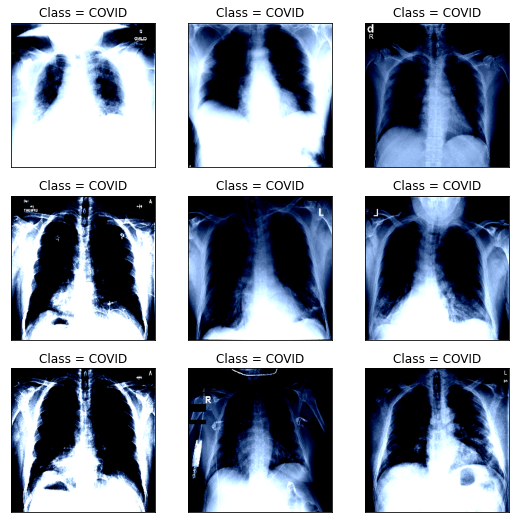

In [ ]:
%matplotlib inline

# plot the images
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 9))
# plot 9 images
for i in range(9):
  image, label = ds_train[i]
  img = image.permute(1, 2, 0)
  ax = plt.subplot(3, 3, i + 1)
  ax.imshow(img.numpy())
  ax.set_title('Class = %s' % CLASSES[int(label.item())])
  ax.set_xticks([])
  ax.set_yticks([])
plt.show()

# Model Training: Fine tuning pretrained model

In [ ]:
# efficient net model -> https://github.com/lukemelas/EfficientNet-PyTorch
!pip install efficientnet_pytorch

In [ ]:
# load a pretrained Densenet 121 model for finetuing on the Chest X_ray images
from efficientnet_pytorch import EfficientNet

if not model_name.startswith('efficientnet'):
  model = torch.hub.load('pytorch/vision:v0.9.0', model_name, pretrained=True)
else:
  model = EfficientNet.from_pretrained(model_name)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


In [ ]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
# Densenet 
if model_name.startswith('densenet'): 
  model.classifier = nn.Linear(model_dict[model_name], num_classes)

if model_name.startswith('efficientnet'):
  print(model_dict[model_name])
  model._fc = nn.Linear(model_dict[model_name], num_classes)
else:
  model.fc = nn.Linear(model_dict[model_name], num_classes)

In [ ]:
# Move the model to CUDA, if available
if torch.cuda.is_available():
  model.to(device)

In [ ]:
from torchkeras import summary
# check the summary of the model 

# summary(model, (3, 256, 256))

In [ ]:
# This code is adapted from https://stackoverflow.com/questions/62265351/measuring-f1-score-for-multiclass-classification-natively-in-pytorch

from typing import Tuple
# Macro F1 score PyTorch

class F1Score:
    """
    Class for f1 calculation in Pytorch.
    """

    def __init__(self, average: str = 'weighted'):
        """
        Init.

        Args:
            average: averaging method
        """
        self.average = average
        if average not in [None, 'micro', 'macro', 'weighted']:
            raise ValueError('Wrong value of average parameter')

    @staticmethod
    def calc_f1_micro(predictions: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Calculate f1 micro.

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels

        Returns:
            f1 score
        """
        true_positive = torch.eq(labels, predictions).sum().float()
        f1_score = torch.div(true_positive, len(labels))
        return f1_score

    @staticmethod
    def calc_f1_count_for_label(predictions: torch.Tensor,
                                labels: torch.Tensor, label_id: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Calculate f1 and true count for the label

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels
            label_id: id of current label

        Returns:
            f1 score and true count for label
        """
        # label count
        true_count = torch.eq(labels, label_id).sum()

        # true positives: labels equal to prediction and to label_id
        true_positive = torch.logical_and(torch.eq(labels, predictions),
                                          torch.eq(labels, label_id)).sum().float()
        # precision for label
        precision = torch.div(true_positive, torch.eq(predictions, label_id).sum().float())
        # replace nan values with 0
        precision = torch.where(torch.isnan(precision),
                                torch.zeros_like(precision).type_as(true_positive),
                                precision)

        # recall for label
        recall = torch.div(true_positive, true_count)
        # f1
        f1 = 2 * precision * recall / (precision + recall)
        # replace nan values with 0
        f1 = torch.where(torch.isnan(f1), torch.zeros_like(f1).type_as(true_positive), f1)
        return f1, true_count

    def __call__(self, predictions: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Calculate f1 score based on averaging method defined in init.

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels

        Returns:
            f1 score
        """

        # simpler calculation for micro
        if self.average == 'micro':
            return self.calc_f1_micro(predictions, labels)

        f1_score = 0
        for label_id in range(1, len(labels.unique()) + 1):
            f1, true_count = self.calc_f1_count_for_label(predictions, labels, label_id)

            if self.average == 'weighted':
                f1_score += f1 * true_count
            elif self.average == 'macro':
                f1_score += f1

        if self.average == 'weighted':
            f1_score = torch.div(f1_score, len(labels))
        elif self.average == 'macro':
            f1_score = torch.div(f1_score, len(labels.unique()))

        return f1_score

In [ ]:
# Define optimizer, loss, macro and micro F1 scores

model.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(model.optimizer, T_max = 5)
model.loss_func = torch.nn.CrossEntropyLoss()
model.macro_f1_score = F1Score(average='macro')
model.micro_f1_score = F1Score(average='micro')

In [ ]:
# sanity check the dataloader: logits and labels
for batch in dl_train:
  logits, labels = batch 
  logits, labels = logits.to(device), labels.to(device)
  print(logits.shape)
  print(labels.shape)
  break

torch.Size([16, 3, 256, 256])
torch.Size([16])


In [ ]:
def train_step(model, features, labels):
  # training
  model.train() 

  model.optimizer.zero_grad()

  logits = model(features)
  loss = model.loss_func(logits, labels)


  # compute the accuracy 
  probs = torch.softmax(logits, dim=1)
  predicted_labels = torch.argmax(logits, dim = 1)

  correct = predicted_labels == labels
  accuracy = correct.sum().float() / float(labels.size(0))

  # F1 metrics
  
  # macro F1 score
  macro_f1_score = model.macro_f1_score(predicted_labels.flatten(), labels.flatten())

  # micro F1 score
  micro_f1_score = model.micro_f1_score(predicted_labels.flatten(), labels.flatten())


  # Backwardprop
  loss.backward()
  model.optimizer.step()
  model.scheduler.step()

  return loss.item(), accuracy, macro_f1_score.item(), micro_f1_score.item()


In [ ]:
def valid_step(model, features, labels):
  # validation
  model.eval()

  with torch.no_grad():
    logits = model(features)
    loss = model.loss_func(logits, labels)
    
    # compute the accuracy 
    probs = torch.softmax(logits, dim=1)
    predicted_labels = torch.argmax(logits, dim = 1)

    correct = predicted_labels == labels
    accuracy = correct.sum().float() / float(labels.size(0))


    # F1 metrics
    
    # macro F1 score
    macro_f1_score = model.macro_f1_score(predicted_labels.flatten(), labels.flatten())

    # micro F1 score
    micro_f1_score = model.micro_f1_score(predicted_labels.flatten(), labels.flatten())

  

  return loss.item(), accuracy, macro_f1_score.item(), micro_f1_score.item()


In [ ]:
%%wandb 

def train_model(model, dl_train, dl_test, epochs, log_freq):
  print('********Training has started***************')


  wandb.watch(model, log='all')


  for epoch in range(1, epochs + 1):
    
    # trainining
    loss_sum = 0.0
    accuracy_sum = 0.0 
    macro_f1_score_sum = 0
    micro_f1_score_sum = 0
    step = 1


    for step, (features, labels) in enumerate(dl_train, 1):
      
      # Migrate the inputs, labels to device
      features, labels = features.to(device), labels.to(device)

      # training step
      loss, accuracy, macro_f1_score, micro_f1_score = train_step(model, features, labels)
     
      # training metrics
      loss_sum+= loss
      accuracy_sum+= accuracy
      macro_f1_score_sum+= macro_f1_score
      micro_f1_score_sum+= micro_f1_score
      
      if step % log_freq == 0:
        print('->[step = % d] loss = %.3f, accuracy = %.3f, macro_F1_score = %.3f, micro_F1_score = %.3f' % 
              (step, loss_sum / step, accuracy_sum / step, macro_f1_score_sum / step, micro_f1_score_sum / step))
  
    # validation 
    val_loss_sum = 0.0
    val_accuracy_sum = 0.0
    val_macro_f1_score_sum = 0
    val_micro_f1_score_sum = 0
    val_step = 1

    for val_step, (features, labels) in enumerate(dl_test, 1):

      # Migrate the inputs, labels to device
      features, labels = features.to(device), labels.to(device)

      # validation step
      val_loss, val_accuracy,  val_macro_f1_score, val_micro_f1_score = valid_step(model, features, labels)

      # validation metrics
      val_loss_sum+= val_loss
      val_accuracy_sum+= val_accuracy
      val_macro_f1_score_sum+= val_macro_f1_score
      val_micro_f1_score_sum+= val_micro_f1_score

    print('\n[Epoch = %d]: loss = %.3f, accuracy = %.3f, val_loss = %.3f, val_accuracy = %.3f, val_macro_F1_score = %.3f, val_micro_F1_score = %.3f' %
          (epoch, loss_sum / step, accuracy_sum / step, val_loss_sum / val_step, val_accuracy_sum / val_step, val_macro_f1_score_sum / val_step, val_micro_f1_score_sum / val_step))
    print("\n"+"=========="*8)


    wandb.log({
        'epoch': epoch,
        'training_loss': loss_sum / step,
        'training_accuracy': accuracy_sum / step,
        'train_macro_f1_score': macro_f1_score_sum / step,
        'train_micro_f1_score': micro_f1_score_sum / step,
        'validation_loss': val_loss_sum / val_step,
        'validation_accuracy': val_accuracy_sum / val_step,
        'val_macro_f1_score': val_macro_f1_score_sum / val_step,
        'val_micro_f1_score': val_micro_f1_score_sum / val_step,
    })
  
  print('**************Fine tuning has Finished**********************')
  validation_accuracy, val_macro_f1_score, val_micro_f1_score = val_accuracy_sum / val_step, val_macro_f1_score_sum / val_step, val_micro_f1_score_sum / val_step

  # saving the model
  torch.save(model.state_dict(), 'model.h5')
  wandb.save('model.h5')

  # Perfomace on the test set 
  print('\n')
  print('*****'*8)
  print('*****'*8)
  print('PERFORMACE ON THE TEST SET')
  print(f'validation_accuracy: {validation_accuracy*100} %,  val_macro_f1_score: {val_macro_f1_score},  val_micro_f1_score: {val_micro_f1_score}')






In [ ]:
def main():
  # wandb initialize a new run
  wandb.init(project='Expand-ai-problem-1')
  wandb.watch_called = False

  config = wandb.config
  config.batch_size = batch_size
  config.epochs = epochs
  config.lr = lr
  config.seed = 42
  config.classes = len(CLASSES)
  config.device = device
  config.model_name = model_name

  # set seed and set cuddn to deterministic for reporducible results
  torch.manual_seed(config.seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

  np.random.seed(config.seed)
  random.seed(config.seed)

  train_model(model, dl_train, dl_test, epochs, log_freq)

 
if __name__=='__main__':
  main()
  wandb.finish()



********Training has started***************
->[step =  10] loss = 1.076, accuracy = 0.419, macro_F1_score = 0.168, micro_F1_score = 0.419
->[step =  20] loss = 0.960, accuracy = 0.534, macro_F1_score = 0.259, micro_F1_score = 0.534
->[step =  30] loss = 0.838, accuracy = 0.638, macro_F1_score = 0.349, micro_F1_score = 0.637
->[step =  40] loss = 0.744, accuracy = 0.711, macro_F1_score = 0.413, micro_F1_score = 0.711

[Epoch = 1]: loss = 0.706, accuracy = 0.732, val_loss = 0.338, val_accuracy = 0.953, val_macro_F1_score = 0.619, val_micro_F1_score = 0.953

->[step =  10] loss = 0.328, accuracy = 0.963, macro_F1_score = 0.643, micro_F1_score = 0.963
->[step =  20] loss = 0.303, accuracy = 0.956, macro_F1_score = 0.626, micro_F1_score = 0.956
->[step =  30] loss = 0.276, accuracy = 0.954, macro_F1_score = 0.625, micro_F1_score = 0.954
->[step =  40] loss = 0.261, accuracy = 0.956, macro_F1_score = 0.626, micro_F1_score = 0.956

[Epoch = 2]: loss = 0.255, accuracy = 0.957, val_loss = 0.163

epoch,30
training_loss,0.00441
training_accuracy,1.0
train_macro_f1_score,0.66667
train_micro_f1_score,1.0
validation_loss,0.0481
validation_accuracy,0.98958
val_macro_f1_score,0.64503
val_micro_f1_score,0.98958
_runtime,466
_timestamp,1623611170


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
training_loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_accuracy,▁▇▇▇█▇████████████████████████
train_macro_f1_score,▁▇▇▇█▇██████████████████▇█████
train_micro_f1_score,▁▇▇▇█▇████████████████████████
validation_loss,█▄▃▂▂▂▂▂▂▂▁▂▂▁▂▂▁▂▂▁▂▁▂▁▁▁▁▁▁▁
validation_accuracy,▁▅▅▇▇█▇▅▆▅▇▇▄▇▆▇▇▃▆▇▇▇▆▆▆▇▇▇▇▇
val_macro_f1_score,▁▂▃▅▅▅▄▇▄▃▃▅▃█▃▃▃▂▃▅▄▅▇▇▃▅▄▅▅▄
val_micro_f1_score,▁▅▄▇▇█▇▅▆▄▇▇▄▇▆▇▇▃▆▇▇▇▆▆▆▇▇▇▇▇
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


# Logging the models: Weights and Biases
## Kindly refer this link to view the training logs, metrics, and artifacts :-> https://wandb.ai/vs74/Expand-ai-problem-1 

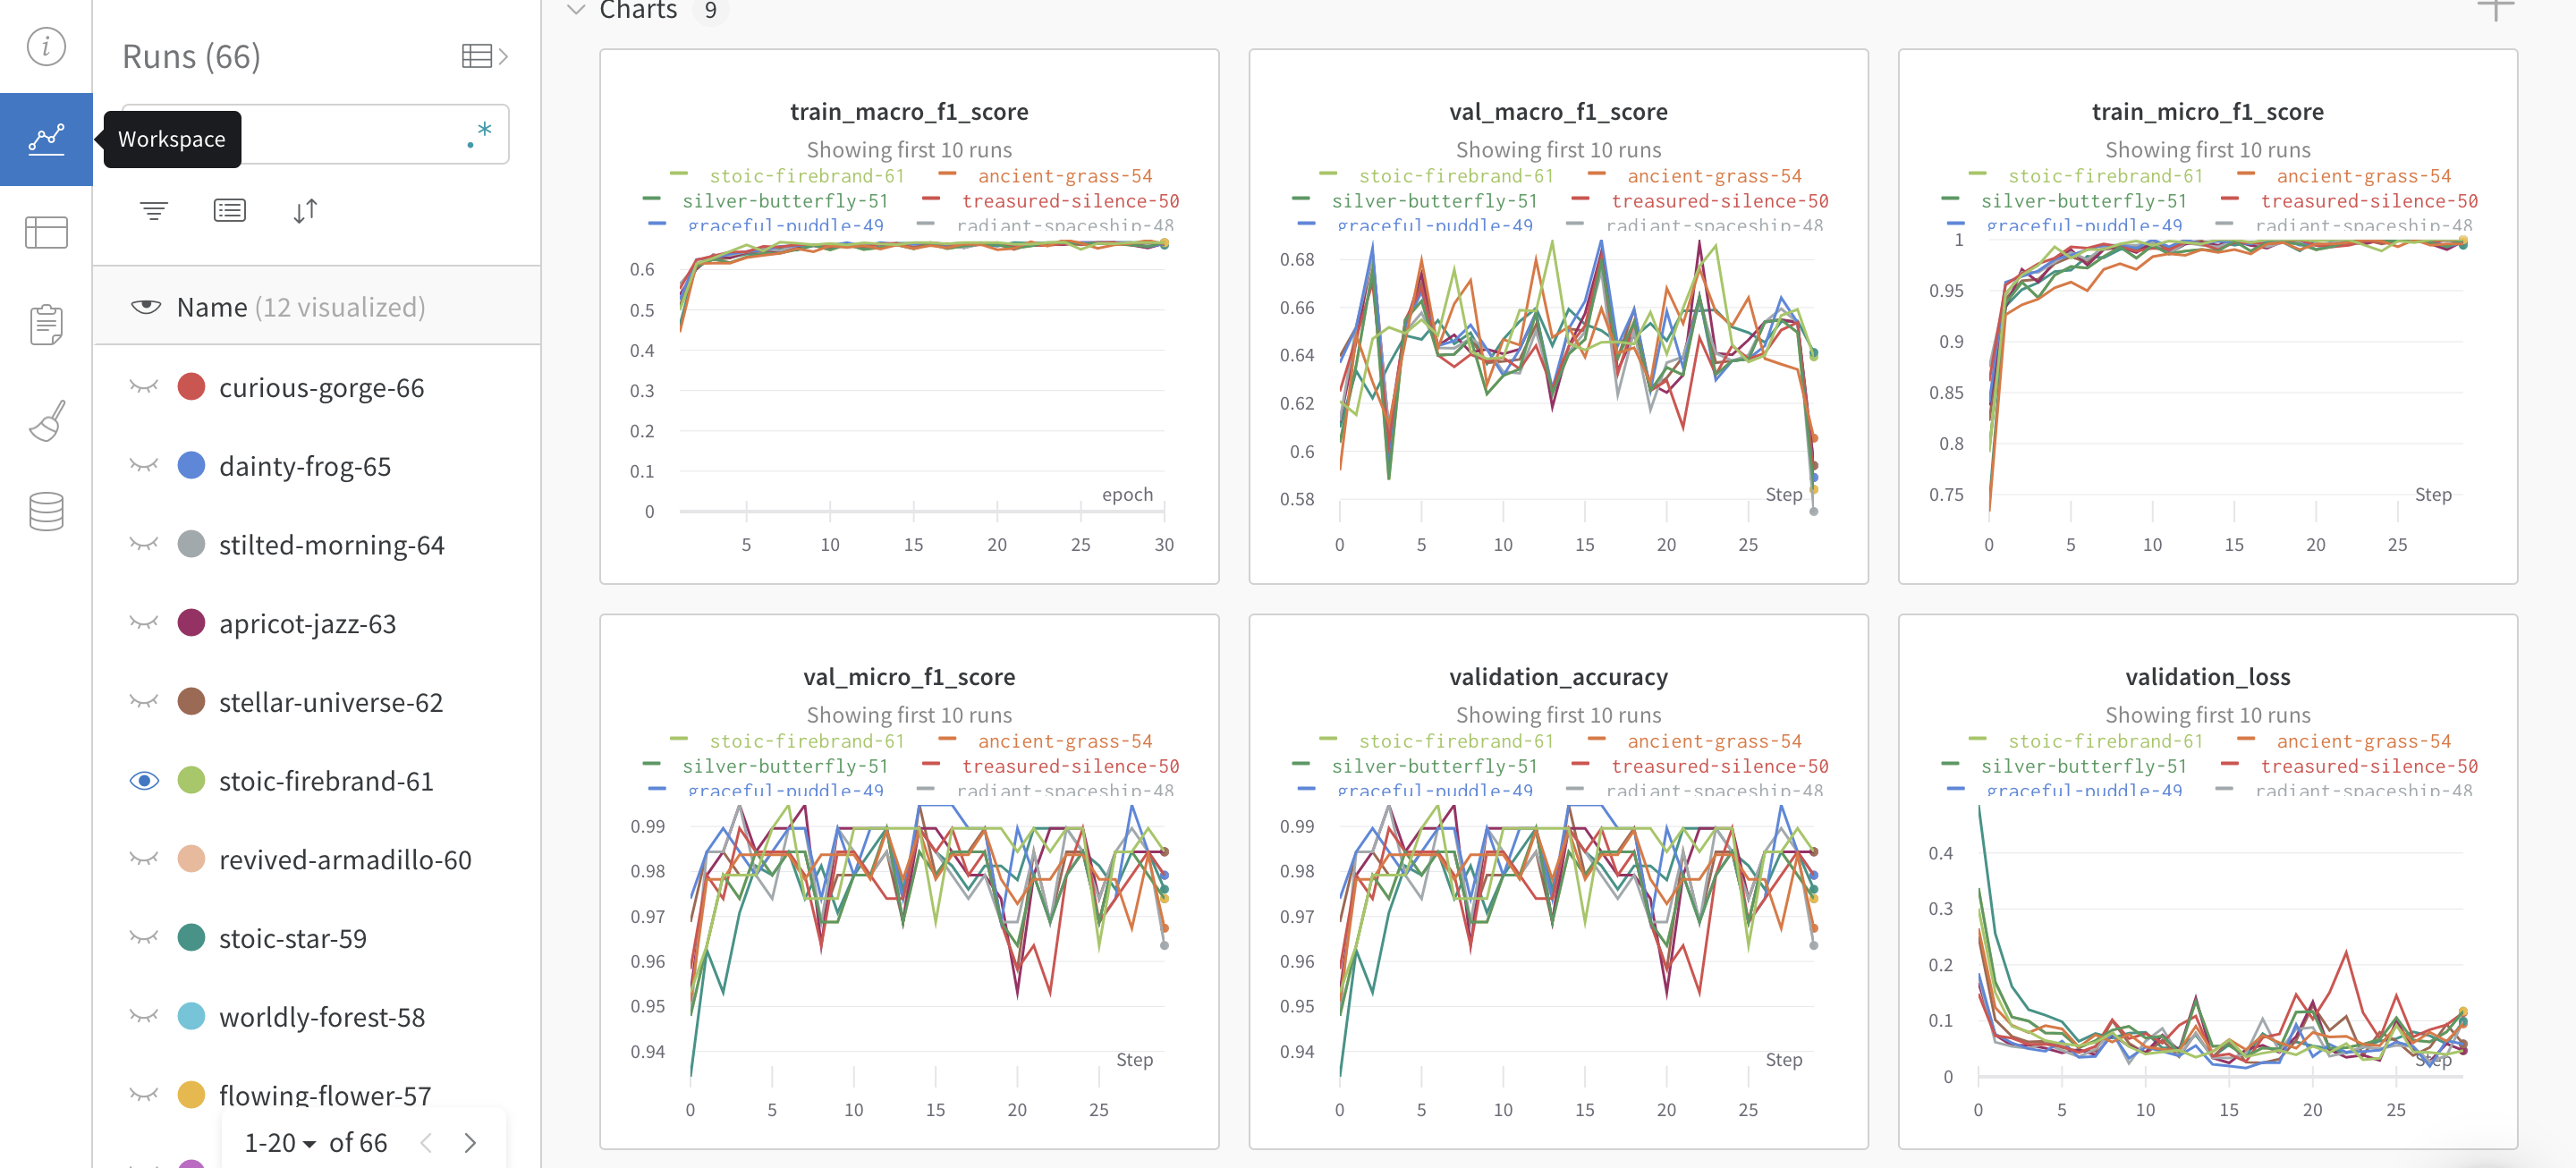